In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.utils.data as data
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
BATCH_SIZE = 128

In [4]:
train_transform_standard = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Grayscale()
        # transforms.Normalize([0.5], [0.5]),
    ]
)

In [5]:
train_dataset = torchvision.datasets.ImageFolder("train_dataset_lpd_filtered_3", transform=train_transform_standard)

train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [6]:
# Pretty good discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n = 32
        self.main = nn.Sequential(
            # BATCH x 128 x 128
            nn.Conv2d(in_channels=1, out_channels=self.n, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(self.n),
            nn.LeakyReLU(0.2, inplace=True),

            # BATCH x 64 x 64
            nn.Conv2d(in_channels=self.n, out_channels=self.n * 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(self.n * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # BATCH x 32 x 32
            nn.Conv2d(in_channels=self.n * 2, out_channels=self.n * 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(self.n * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # BATCH x 16 x 16
            nn.Conv2d(in_channels=self.n * 4, out_channels=self.n * 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(self.n * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # BATCH x 8 x 8
            nn.Conv2d(in_channels=self.n * 8, out_channels=self.n * 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(self.n * 16),
            nn.LeakyReLU(0.2, inplace=True),

            # BATCH x 4 x 4
            nn.Conv2d(in_channels=self.n * 16, out_channels=1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),

            # BATCH x 2 x 2
            nn.Flatten(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def __str__(self) -> str:
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return super().__str__() + "\nTrainable parameters: {}".format(params)

    def forward(self, input):
        return self.main(input)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n = 512
        self.main = nn.Sequential(
            # Batch_size x n x kernel_size x kernel_size -> Batch_size x n x 4 x 4
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=self.n, kernel_size=(4, 4), bias=False),
            nn.BatchNorm2d(self.n),
            nn.LeakyReLU(0.2, inplace=True),

            # -> Batch_size x n x 8 x 8
            nn.ConvTranspose2d(in_channels=self.n, out_channels=self.n // 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(self.n // 2),
            nn.ReLU(True),

            # -> Batch_size x n x 16 x 16
            nn.ConvTranspose2d(in_channels=self.n // 2, out_channels=self.n // 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(self.n // 4),
            nn.LeakyReLU(0.2, inplace=True),

            # -> Batch_size x n x 32 x 32
            nn.ConvTranspose2d(in_channels=self.n // 4, out_channels=self.n // 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(self.n // 8),
            nn.LeakyReLU(0.2, inplace=True),

            # -> Batch_size x n x 64 x 64
            nn.ConvTranspose2d(in_channels=self.n // 8, out_channels=self.n // 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(self.n // 16),
            nn.LeakyReLU(0.2, inplace=True),

            # -> Batch_size x n x 128 x 128
            nn.ConvTranspose2d(in_channels=self.n // 16, out_channels=1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Sigmoid()
        )

    def __str__(self) -> str:
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return super().__str__() + "\nTrainable parameters: {}".format(params)

    def forward(self, input):
        return self.main(input)

In [8]:
latent_dim = 100
fixed_noise = torch.randn(128, latent_dim, 1, 1, device=device)

# Models
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

generator = torch.load('generator.pt', map_location=device)
discriminator = torch.load('discriminator.pt', map_location=device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [9]:
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_siz

In [10]:
epoch_info = [0, 2, 5, 10, 20, 40, 60, 100, 140, 180, 250, 300, 350, 399]
G_losses = []
D_losses = []
img_list = []
num_epochs = 400
for epoch in range(num_epochs):
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):
        ############################
        # (1) Update Discriminator
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        error_discriminator_real.backward()
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        # fake_images = modify_generator_pictures(fake_images)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update Generator
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())
    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    if epoch in epoch_info:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

KeyboardInterrupt: 

In [ ]:
torch.save(generator, 'generator.pt')
torch.save(discriminator, 'discriminator.pt')

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=250, blit=True)

HTML(ani.to_jshtml())

In [15]:
from music21 import instrument, note, chord, stream

lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.1
def updateNotes(newNotes,prevNotes):
    res = {}
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

In [16]:
def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        try:
            print(image.size[1], image.size[0])
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    name = image_path
    name.replace(".png",".mid")
    print(name)

    midi_stream.write('midi', 'composition.mid')

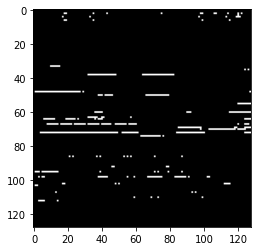

In [13]:
noise = torch.randn(1, latent_dim, 1, 1, device=device)
THRESHOLD = 0.5
fake = generator(noise).detach().cpu().numpy()
fake = fake.reshape((128, 128))
fake[fake >= THRESHOLD] = 1
fake[fake < THRESHOLD] = 0
# fake = fake.astype(np.uint8)
plt.imshow(fake, cmap='gray')
# fake.shape

In [17]:
from PIL import Image
array = np.array(fake, dtype = np.uint8)
array*= 255
new_image = Image.fromarray(array,'L')
new_image = new_image.save('composition.png')
image2midi('composition.png')

128 128
composition.png


C:\Users\mateu\AppData\Local\Temp/ipykernel_12936/2744369202.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)


# Useful functions for CNN

In [18]:
def conv_size(input_size, padding, kernel_size, stride):
    return (input_size + 2 * padding - (kernel_size - 1) - 1) / stride + 1

In [19]:
def transpose_conv_size(input_size, padding, kernel_size, stride):
    return (input_size - 1) * stride - 2 * padding + kernel_size

In [85]:
input_size = 384
stride = 1
padding = 1
kernel_size = 3
# transpose_conv_size(input_size=input_size, padding=padding, kernel_size=kernel_size, stride=stride)
conv_size(input_size=input_size, padding=padding, kernel_size=kernel_size, stride=stride)

384.0

In [ ]:
conv_size(input_size=input_size, padding=padding, kernel_size=kernel_size, stride=stride)

In [ ]:
transpose_conv_size(input_size=input_size, padding=padding, kernel_size=kernel_size, stride=stride)

# Test .bmp samples

In [ ]:
from PIL import Image
import pypianoroll

In [ ]:
IMAGE_PATH = 'train_dataset_lpd/train/1772_train.bmp'
img = Image.open(IMAGE_PATH)
array = np.array(img)

pr = pypianoroll.Multitrack()

In [ ]:
pr.append(pypianoroll.BinaryTrack(pianoroll=array.transpose()))

In [ ]:
pr.plot()

In [ ]:
pr.write('test.midi')